<a href="https://colab.research.google.com/github/nmcardoso/galmorpho/blob/master/splus_stamps_preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ganerate galaxy stamps from SPLUS


## Imports



In [ ]:
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
from astropy.io import fits
from astropy.nddata.utils import Cutout2D
from scipy import ndimage
import numpy as np
import glob
import pandas as pd
import os
import shutil
import tarfile
from zipfile import ZipFile
from multiprocessing import Pool, Lock
from ipywidgets import FloatProgress
from progressbar import progressbar
plt.style.use(astropy_mpl_style)

## Globals

In [ ]:
RAW_STAMPS_PATH = '/content/drive/My Drive/splus_data/stamps'
# DATAFRAME_PATH = '/content/drive/My Drive/splus_data/tables/group_2_zoo2.csv'
DATAFRAME_PATH = '/content/drive/My Drive/splus_data/tables/SPLUS_SQGTool_DR1_v3.0_group2_MATCH_SAMPLE_zoo2.csv'

In [ ]:
RAW_STAMPS_PATH = '/home/natan/splus_data/stamps'
DATAFRAME_PATH = '/home/natan/splus_data/tables/main_table.csv'
# DATAFRAME_PATH = '/home/natan/splus_data/tables/SPLUS_SQGTool_DR1_mag-17_p_gal_sw_0.7-1.0_group_2_zoo2.csv'

## Preprocess Class

In [ ]:
class Preprocess:
  def __init__(self, files_folder, channels, labels, image_dim):
    # NaN, n < 0, n < median -> 0
    normalization_function = lambda e, median: e if (not np.isnan(e)) and (e > median) and (e > 0.0) else 0.0
    self.norm_vector = np.vectorize(normalization_function)
    self.files_folder = files_folder
    self.labels = labels
    self.image_dim = image_dim
    self.channels = channels
  
  def remove_sky(self, image_array):
    median = np.median(image_array)
    image = self.norm_vector(image_array, median)
    return image

  def rescale(self, image_array):
    image = image_array.copy()
    image /= np.amax(image)
    return image

  def standarize(self, image_array):
    image = image_array.copy()
    image -= np.mean(image)
    image /= np.std(image)
    return image

  def cutout(self, position, size):
    def cutout_func(image_array):
      image = Cutout2D(image_array, position, size)
      image = image.data
      return image
    return cutout_func

  def zoom(self, factor):
    def zoom_func(image_array):
      image = ndimage.zoom(image_array, factor)
      return image
    return zoom_func

  def dataset_median(self):
    median = {}
    for channel in self.channels:
      median[channel] = []
      for row in progressbar(self.labels.iterrows(), max_value=self.labels.shape[0]):
        image_path = os.path.join(self.files_folder, channel, f'{row[1].ID}_{channel}.fits')
        image_array = fits.getdata(image_path, ext=0)
        median[channel].append(np.median(image_array))
    return median
  
  def exec_pipeline(self, functions, output_path, remove=False, compress=False, limit=None):
    if output_path is None:
      print('Specify output path')
      return
    if not os.path.isdir(output_path):
      os.makedirs(output_path)

    for row in progressbar(self.labels.iterrows(), max_value=self.labels.shape[0]):
      image_id = row[1].ID
      image = np.empty((*self.image_dim, len(self.channels)))

      for i, channel in enumerate(self.channels):
        image_path = os.path.join(self.files_folder, channel, f'{image_id}_{channel}.fits')
        image_array = fits.getdata(image_path, ext=0)
        if remove:
          os.remove(image_path) #remove .fits image
        for f in functions:
          image_array = f(image_array)
        image[..., i] = image_array
      
      npy_path = os.path.join(output_path, f'{image_id}.npy')
      np.save(npy_path, image)

      if compress:
        with tarfile.open(os.path.join(output_path, 'dataset.tar'), 'a') as tar:
          tar.add(npy_path, f'{image_id}.npy')

        os.remove(npy_path) # remove .npy file

## Get data from gdrive

In [ ]:
!ls "{RAW_STAMPS_PATH}"

F378_stamps.tar.xz  F430_stamps.tar.xz	F861_stamps.tar.xz  R_stamps.tar.xz
F395_stamps.tar.xz  F515_stamps.tar.xz	G_stamps.tar.xz     U_stamps.tar.xz
F410_stamps.tar.xz  F660_stamps.tar.xz	I_stamps.tar.xz     Z_stamps.tar.xz


In [ ]:
!tar -C /content -xvf "$RAW_STAMPS_PATH/F378_stamps.tar.xz"
!tar -C /content -xvf "$RAW_STAMPS_PATH/F395_stamps.tar.xz"
!tar -C /content -xvf "$RAW_STAMPS_PATH/F410_stamps.tar.xz"
!tar -C /content -xvf "$RAW_STAMPS_PATH/F430_stamps.tar.xz"
!tar -C /content -xvf "$RAW_STAMPS_PATH/F515_stamps.tar.xz"
!tar -C /content -xvf "$RAW_STAMPS_PATH/F660_stamps.tar.xz"
!tar -C /content -xvf "$RAW_STAMPS_PATH/F861_stamps.tar.xz"
!tar -C /content -xvf "$RAW_STAMPS_PATH/G_stamps.tar.xz"
!tar -C /content -xvf "$RAW_STAMPS_PATH/I_stamps.tar.xz"
!tar -C /content -xvf "$RAW_STAMPS_PATH/R_stamps.tar.xz"
!tar -C /content -xvf "$RAW_STAMPS_PATH/U_stamps.tar.xz"
!tar -C /content -xvf "$RAW_STAMPS_PATH/Z_stamps.tar.xz"

tar: /content/drive/My Drive/splus_data/stamps/F660_stamps.tar.xz: Cannot read: Input/output error
tar: At beginning of tape, quitting now
tar: Error is not recoverable: exiting now


In [ ]:
!mkdir /content/data

In [ ]:
!mv F378/F378_stamps/ data/F378
!mv F395/F395_stamps/ data/F395
!mv F410/F410_stamps/ data/F410
!mv F430/F430_stamps/ data/F430
!mv F515/F515_stamps/ data/F515
!mv F660/F660_stamps/ data/F660
!mv F861/F861_stamps/ data/F861
!mv G/G_stamps data/G
!mv I_stamps/ data/I
!mv R_stamps data/R
!mv U/U_stamps/ data/U
!mv Z/Z_stamps data/Z

## Start Job

In [ ]:
def create_sub_dataframe():
  df = pd.read_csv(DATAFRAME_PATH)
  df = df[['ID', 'simple_class']]
  df = df.rename(columns={'simple_class': 'CLASS'})
  df['CLASS'] = df['CLASS'].apply(lambda x: x[0])
  df_E = df[df.CLASS == 'E']
  df_E = df_E[3600:]
  df_S = df[df.CLASS == 'S']
  df = pd.concat([df_E, df_S])
  df.to_csv('/content/dataset.csv', index=False)
  return df

In [ ]:
def create_dataframe():
  df = pd.read_csv(DATAFRAME_PATH)
  df = df[['ID', 'simple_class']]
  df = df.rename(columns={'simple_class': 'CLASS'})
  df['CLASS'] = df['CLASS'].apply(lambda x: x[0])
  df = df[df.CLASS != 'A']
  df.to_csv('/content/dataset.csv', index=False)
  return df

In [ ]:
df = pd.read_csv(DATAFRAME_PATH)
p = Preprocess(RAW_STAMPS_PATH, ['F378', 'F395', 'F410', 'F430', 'F515', 'F660', 'F861', 'G', 'I', 'R', 'U', 'Z'], df, (64, 64))
p.exec_pipeline([p.cutout((128, 128), 128), p.zoom(.5), p.remove_sky, p.rescale], '/home/natan/splus_data/stacked_stamps')

## Export to gdrive

In [ ]:
!cp "/content/dataset.csv" "/content/drive/My Drive/datasets/stamps_scaled_12ch_subset_128px.csv"
!cp "/content/dataset.tar" "/content/drive/My Drive/datasets/stamps_scaled_12ch_subset_128px.tar"

## Tests

[[ 0.16219707  0.03844285 -0.00833612 ...  0.01060256  0.01142766
   0.06859117]
 [-0.0236338   0.00994077  0.04086182 ... -0.05307572  0.15417303
   0.13643812]
 [-0.0738645  -0.03495217  0.03109588 ...  0.03601837  0.1581655
   0.0846342 ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[[-0.00091782 -0.08081905  0.0221798  ... -0.11530694  0.00437685
  -0.02777974]
 [ 0.12616119  0.04785838  0.00760942 ... -0.0743298   0.0311547
   0.03129177]
 [-0.01115931  0.03756567  0.06529465 ...  0.10882592  0.00885398
   0.0871751 ]
 ...
 [-0.00593879  0.0063269   0.0101673  ...  0.00755543 -0.00094272
   0.00447489]
 [-0.01241871 -0.01069971 -0.00816834 ... -0.004268    0.00948802
  -0.0072239 ]
 [ 0.00081001 -0.00950094  0.00730772 ...  0.01033255  0.00174367
  -0.00805178]]
[[-0.00091782  0.02295595  0.05116727 ... 

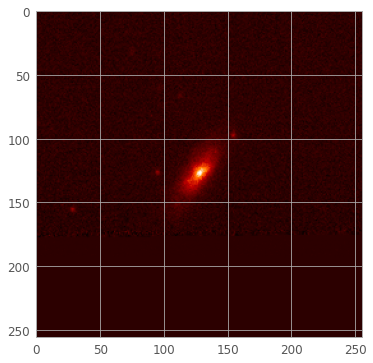

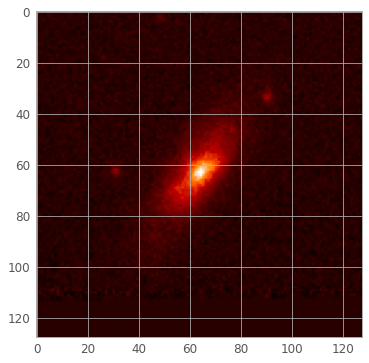

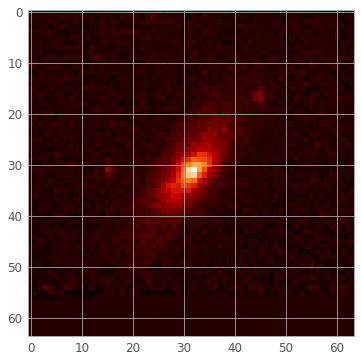

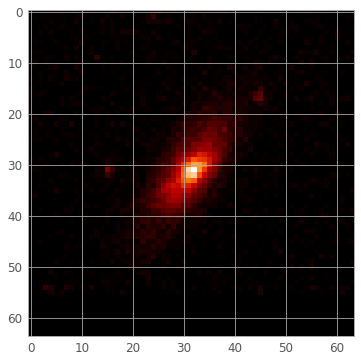

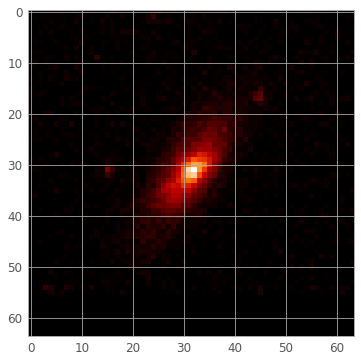

In [ ]:
p = Preprocess(RAW_STAMPS_PATH, ['F378', 'F395', 'F410', 'F430', 'F515', 'F660', 'F861', 'G', 'I', 'R', 'U', 'Z'], df, (128, 128))
im = fits.getdata(f'{RAW_STAMPS_PATH}/R/SPLUS.STRIPE82-0035.11578.griz_R.fits')
plt.figure()
plt.imshow(im)
print(im)

_im = p.cutout((128, 128), 128)(im)
plt.figure()
plt.imshow(_im)
print(_im)

_im = p.zoom(.5)(_im)
plt.figure()
plt.imshow(_im)
print(_im)
print(np.amin(_im), np.amax(_im))

_im = p.remove_sky(_im)
plt.figure()
plt.imshow(_im)
print(_im)

_im = p.rescale(_im)
plt.figure()
plt.imshow(_im)
print(_im)
print(np.amin(_im), np.amax(_im))


# Median

In [ ]:
df = create_dataframe()
p = Preprocess('/content/data', ['R', 'G', 'Z'], df, (256, 256))
m = p.dataset_mean()

R_mean_min: -0.08060667 R_mean_max: 28.34475


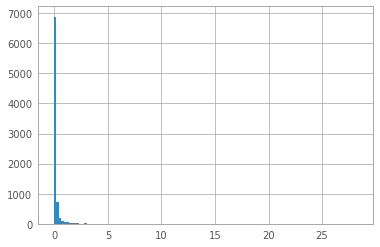

G_mean_min: -0.04681581 G_mean_max: 15.430484


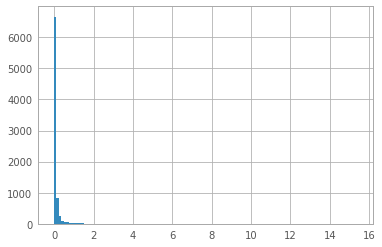

Z_mean_min: -0.40006396 Z_mean_max: 21.851059


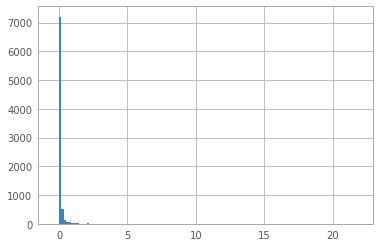

In [ ]:
print('R_median_min:', np.amin(m['R']), 'R_median_max:', np.amax(m['R']))
plt.figure()
plt.hist(m['R'], bins=120)
plt.show()
print('G_median_min:', np.amin(m['G']), 'G_median_max:', np.amax(m['G']))
plt.figure()
plt.hist(m['G'], bins=120)
plt.show()
print('Z_median_min:', np.amin(m['Z']), 'Z_median_max:', np.amax(m['Z']))
plt.figure()
plt.hist(m['Z'], bins=120)
plt.show()